## 1.Azmeraw bekele...............GSR/3194/14
##2.Tadele melese................GSR/5701/14
## 3. Diyawdin menu................GSR/1558/14


In [ ]:
!pip install -q causalgraphicalmodels
!pip install -q pgmpy
!pip install superimport

!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pgmpy_utils.py


     |████████████████████████████████| 1.9 MB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for superimport: filename=superimport-0.3.4-py3-none-any.whl size=5888 sha256=cf5f2d3f79ecf8aba832e5c46f435188fc5c5b10a765f64980b3d579ce90e5dc
  Stored in directory: /root/.cache/pip/wheels/6c/66/dc/337052d868002cf3830606ee34d91d1ceff6a67bf8df982c72
Successfully built superimport


In [ ]:

from causalgraphicalmodels import CausalGraphicalModel
import numpy as np
import pandas as pd
import math
import itertools


# Model

In [ ]:

class Element:
    def __init__(self, name):
        self._name = name if name is not None else str(id(self))

    def __str__(self):
        return self._name

    @property
    def name(self):
        return self._name


class Variable(Element):
    def __init__(self, domain=None, name=None):
        Element.__init__(self, name)
        self._domain = tuple(sorted(set(domain))) if domain is not None else None
        self._linked_factors = []

    @staticmethod
    def evaluate_variables(variables):
        domains = (variable.domain for variable in variables)
        return tuple(itertools.product(*domains))

    @staticmethod
    def split_evidential_and_non_evidential_variables(variables, without_variables=()):
        evidential_variables = []
        non_evidential_variables = []
        for variable in variables:
            if variable not in without_variables:
                if variable.is_evidential():
                    evidential_variables.append(variable)
                else:
                    non_evidential_variables.append(variable)
        return tuple(evidential_variables), tuple(non_evidential_variables)

    @property
    def domain(self):
        return self._domain

    @property
    def factors(self):
        return self._linked_factors

    @property
    def factors_number(self):
        return len(self._linked_factors)

    def check_value(self, value):
        if self.is_value_illegal(value):
            raise ValueError(f'variable {self.name} cannot have the value of {value}')

    def is_evidential(self):
        return len(self._domain) == 1

    def is_value_illegal(self, value):
        return value not in self._domain

    def is_value_legal(self, value):
        return value in self._domain

    def is_leaf(self):
        return 0 <= len(self._linked_factors) <= 1

    def link_factor(self, factor):
        self._linked_factors.append(factor)

    def set_domain(self, domain):
        self._domain = tuple(sorted(set(domain)))


def log(f):
    def log_f(*t):
        return math.log(f(*t))
    return log_f


class Factor(Element):
    def __init__(self, variables, function=None, name=None, evidence=None, variable_linking=True):
        Element.__init__(self, name)
        self._variables = tuple(variables)
        self._function = function
        self._evidence_var_val_dict = {}
        if variable_linking:
            self._link_factor_to_variables()
        self._set_evidence(evidence)

    def __call__(self, *variables_with_values):
        var_val_dict = {}
        var_val_dict.update(self._evidence_var_val_dict)
        var_val_dict.update(dict(variables_with_values))
        values = (var_val_dict[var] for var in self._variables)
        return self._function(*values)

    def __str__(self):
        variables_names = (variable.name for variable in self._variables)
        return self._name + '(' + ', '.join(variables_names) + ')'

    @property
    def evidence(self):
        return self._evidence_var_val_dict.keys()

    @property
    def function(self):
        return self._function

    @property
    def variables(self):
        return self._variables

    @property
    def variables_number(self):
        return len(self._variables)

    def add_evidence(self, variable):
        if not isinstance(variable, Variable):
            raise ValueError(f'object {variable} is not an instance of class Variable')
        if not variable.is_evidential():
            raise ValueError(f'variable {variable.name} is not evidential')
        if variable not in self._variables:
            raise ValueError(f'variable {variable.name} does not belong to '
                             f'the factor variables {tuple(var.name for var in self._variables)}')
        self._evidence_var_val_dict[variable] = variable.domain[0]

    def clear_evidence(self):
        del self._evidence_var_val_dict
        self._evidence_var_val_dict = {}

    def delete_evidence(self, variable):
        if not isinstance(variable, Variable):
            raise ValueError(f'object {variable} is not an instance of class Variable')
        if variable not in self._variables:
            raise ValueError(f'variable {variable.name} does not belong to '
                             f'the factor variables {tuple(var.name for var in self._variables)}')
        try:
            del self._evidence_var_val_dict[variable]
        except KeyError:
            raise ValueError(f'variable {variable.name} is not evidential')

    def filter_values(self, *variables_with_values):
        return tuple(var_val for var_val in variables_with_values if var_val[0] in self._variables)

    def is_leaf(self):
        return len(self._variables) == 1

    def logarithm(self):
        self._function = log(self._function)
        self._name = 'log_' + self._name

    def _link_factor_to_variables(self):
        for var in self._variables:
            var.link_factor(self)

    def _set_evidence(self, evidence):
        self._evidence_var_val_dict = {var: var.domain[0] for var in evidence} if evidence else {}


#FactorGraph
class FactorGraph:
    def __init__(self, factors):
        self._factors = sorted(
            set(factors),
            key=lambda f: f.name
        )
        self._variables = sorted(
            set(variable
                for factor in self._factors
                for variable in factor.variables
                ),
            key=lambda v: v.name
        )
        self._factor_dict = None
        self._variable_dict = None

    @property
    def factors(self):
        return self._factors

    @property
    def factor_leaves(self):
        return tuple(factor for factor in self._factors if factor.is_leaf())

    @property
    def factor_variables(self):
        return tuple(factor.variables for factor in self._factors)

    @property
    def variables(self):
        return self._variables

    @property
    def variable_leaves(self):
        return tuple(variable for variable in self._variables if variable.is_leaf())

    def get_factor(self, name):
        if self._factor_dict is None:
            self._set_factor_dict()
        try:
            return self._factor_dict[name]
        except KeyError:
            raise AttributeError(f'factor {name} not found')

    def get_variable(self, name):
        if self._variable_dict is None:
            self._set_variable_dict()
        try:
            return self._variable_dict[name]
        except KeyError:
            raise AttributeError(f'variable {name} not found')

    def _set_factor_dict(self):
        self._factor_dict = {factor.name: factor for factor in self._factors}

    def _set_variable_dict(self):
        self._variable_dict = {variable.name: variable for variable in self._variables}

In [ ]:



class MN(FactorGraph):

    def __init__(self):        
        difficulty = Variable(domain={'d0', 'd1'}, name='Difficulty')
        intelligence = Variable(domain={'i0', 'i1'}, name='Intelligence')
        grade = Variable(domain={'g0', 'g1', 'g2'}, name='Grade')
        sat = Variable(domain={'s0', 's1'}, name='SAT')
        letter = Variable(domain={'l0', 'l1'}, name='Letter')

        # Create factor values
        dict_ab = {
            ('d0', 'g0'): 30,
            ('d0', 'g1'): 5,
            ('d1', 'g0'): 1,
            ('d1', 'g1'): 10
        }


        dict_bc = {
            ('g0', 'i0'): 100,
            ('g0', 'i1'): 1,
            ('g1', 'i0'): 1,
            ('g1', 'i1'): 100
        }
        dict_cd = {
            ('g0', 'l0'): 1,
            ('g0', 'l1'): 100,
            ('g1', 'l0'): 100,
            ('g1', 'l1'): 1
        }
        dict_de = {
            ('i0', 's0'): 100,
            ('i0', 's1'): 1,
            ('i1', 's0'): 1,
            ('i1', 's1'): 100
        }
        dict_ea = {
            ('d0', 'i0'): 30,
            ('d0', 'i1'): 5,
            ('d1', 'i0'): 1,
            ('d1', 'i1'): 10
        }


        # Create factors
        f_ab = Factor(
            variables=(difficulty, grade),
            function=lambda a, b: dict_ab[(a, b)],
            name='f_ab'
        )
        f_bc = Factor(
            variables=(difficulty, intelligence),
            function=lambda b, c: dict_bc[(b, c)],
            name='f_bc'
        )
        f_cd = Factor(
            variables=(grade, intelligence),
            function=lambda c, d: dict_cd[(c, d)],
            name='f_cd'
        )
        f_de = Factor(
            variables=(intelligence, sat),
            function=lambda d, e: dict_de[(d, e)],
            name='f_de'
        )        
        f_ea = Factor(
            variables=(grade, letter),
            function=lambda e, a: dict_ea[(e, a)],
            name='f_ea'
        )


        # Create a factorization
        factors = {f_ab, f_bc, f_cd, f_de,f_ea}

        # Create a factor graph
        FactorGraph.__init__(self, factors)

class BN(FactorGraph):

    def __init__(self):
        # Create random variables
        difficulty = Variable(domain={'d0', 'd1'}, name='Difficulty')
        intelligence = Variable(domain={'i0', 'i1'}, name='Intelligence')
        grade = Variable(domain={'g0', 'g1', 'g2'}, name='Grade')
        sat = Variable(domain={'s0', 's1'}, name='SAT')
        letter = Variable(domain={'l0', 'l1'}, name='Letter')

        # Create conditional probability distributions (CPDs)
        cpd_difficulty = { 'd0': 0.6,'d1': 0.4}
        cpd_intelligence = {'i0': 0.7,'i1': 0.3}
        cpd_grade = {('d0', 'i0'): {'g0': 0.30, 'g1': 0.40, 'g2': 0.30},
                    ('d0', 'i1'): {'g0': 0.90, 'g1': 0.08, 'g2': 0.02},
                    ('d1', 'i0'): {'g0': 0.05, 'g1': 0.25, 'g2': 0.70},
                    ('d1', 'i1'): {'g0': 0.50, 'g1': 0.30, 'g2': 0.20}}
        cpd_sat = {'i0': {'s0': 0.95, 's1': 0.05},'i1': {'s0': 0.20, 's1': 0.80}}
        cpd_letter = {'g0': {'l0': 0.10, 'l1': 0.90},
                    'g1': {'l0': 0.40, 'l1': 0.60},
                    'g2': {'l0': 0.99, 'l1': 0.01}}

        # Create factors
        f_d = Factor( variables=(difficulty, ), function=lambda d: cpd_difficulty[d], name='f_d')
        f_i = Factor(variables=(intelligence, ),function=lambda i: cpd_intelligence[i],name='f_i')
        f_dig = Factor(variables=(difficulty,intelligence,grade),function=lambda d, i, g: cpd_grade[(d, i)][g],name='f_dig')
        f_is = Factor(variables=(intelligence,sat),function=lambda i, s: cpd_sat[i][s],name='f_is')
        f_gl = Factor(variables=(grade,letter),function=lambda g, l: cpd_letter[g][l],name='f_gl')
        print(f_d ((difficulty, 'd1')))
        
        # Create a factorization
        factors = {f_d, f_i,f_dig,f_is,f_gl}
         
        # Create a factor graph from the factors
        FactorGraph.__init__(self, factors)


from causalgraphicalmodels import CausalGraphicalModel
if __name__ == '__main__':

    modele = BN()
    model2=MN()
    for factor in modele.factors:
        print("CDP-Variabless:",factor)
    for variable in modele.variables:
        print("nodes:",variable)
    for factor in model2.factors:
        print("Factors:", factor)
    for variable in model2.variables:
        print("nodes:",variable)

    """
    model2 = CausalGraphicalModel(nodes = modele.variables(), edges=modele.factors())
    dot = model2.draw()
    print(type(dot))
    display(dot)
    """

0.4
CDP-Variabless: f_d(Difficulty)
CDP-Variabless: f_dig(Difficulty, Intelligence, Grade)
CDP-Variabless: f_gl(Grade, Letter)
CDP-Variabless: f_i(Intelligence)
CDP-Variabless: f_is(Intelligence, SAT)
nodes: Difficulty
nodes: Grade
nodes: Intelligence
nodes: Letter
nodes: SAT
Factors: f_ab(Difficulty, Grade)
Factors: f_bc(Difficulty, Intelligence)
Factors: f_cd(Grade, Intelligence)
Factors: f_de(Intelligence, SAT)
Factors: f_ea(Grade, Letter)
nodes: Difficulty
nodes: Grade
nodes: Intelligence
nodes: Letter
nodes: SAT


In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.

model = BayesianModel([('Difficulty', 'Grade'), ('Inteligence', 'Grade'), ('Grade', 'Letter'), ('Inteligence', 'SAT')])
print(model)


BayesianModel with 5 nodes and 4 edges


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


## **Parameterization**

In [ ]:
# Defining individual CPDs.
cpd_d = TabularCPD(variable='Difficulty', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='Inteligence', variable_card=2, values=[[0.7], [0.3]])



cpd_g = TabularCPD(variable='Grade', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['Inteligence', 'Difficulty'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='Letter', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['Grade'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='SAT', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['Inteligence'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [ ]:
print(cpd_i)

+----------------+-----+
| Inteligence(0) | 0.7 |
+----------------+-----+
| Inteligence(1) | 0.3 |
+----------------+-----+


In [ ]:
print(cpd_d)

+---------------+-----+
| Difficulty(0) | 0.6 |
+---------------+-----+
| Difficulty(1) | 0.4 |
+---------------+-----+


In [ ]:
print(cpd_g)

+-------------+----------------+-----+----------------+----------------+
| Inteligence | Inteligence(0) | ... | Inteligence(1) | Inteligence(1) |
+-------------+----------------+-----+----------------+----------------+
| Difficulty  | Difficulty(0)  | ... | Difficulty(0)  | Difficulty(1)  |
+-------------+----------------+-----+----------------+----------------+
| Grade(0)    | 0.3            | ... | 0.9            | 0.5            |
+-------------+----------------+-----+----------------+----------------+
| Grade(1)    | 0.4            | ... | 0.08           | 0.3            |
+-------------+----------------+-----+----------------+----------------+
| Grade(2)    | 0.3            | ... | 0.02           | 0.2            |
+-------------+----------------+-----+----------------+----------------+


In [ ]:
print(cpd_s)

+-------------+----------------+----------------+
| Inteligence | Inteligence(0) | Inteligence(1) |
+-------------+----------------+----------------+
| SAT(0)      | 0.95           | 0.2            |
+-------------+----------------+----------------+
| SAT(1)      | 0.05           | 0.8            |
+-------------+----------------+----------------+


In [ ]:
print(cpd_l)

+-----------+----------+----------+----------+
| Grade     | Grade(0) | Grade(1) | Grade(2) |
+-----------+----------+----------+----------+
| Letter(0) | 0.1      | 0.4      | 0.99     |
+-----------+----------+----------+----------+
| Letter(1) | 0.9      | 0.6      | 0.01     |
+-----------+----------+----------+----------+


**DAG-Visualization**

<class 'graphviz.dot.Digraph'>


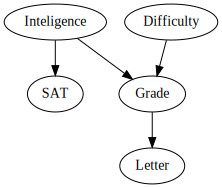

In [ ]:
model2 = CausalGraphicalModel(nodes = model.nodes(), edges=model.edges())

dot = model2.draw()
print(type(dot))
display(dot)
#dot.render(filename='student_pgm', format='pdf')
# creates student_pgm (a text file of the graph) and student_pgm.pdf

In [ ]:
mm = model.to_markov_model()

mm.edges()

EdgeView([('Difficulty', 'Grade'), ('Difficulty', 'Inteligence'), ('Grade', 'Letter'), ('Grade', 'Inteligence'), ('Inteligence', 'SAT')])

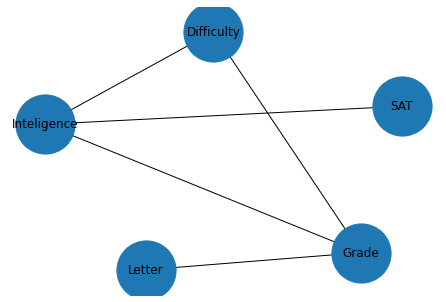

In [ ]:

import networkx as nx
import pylab as plt
nx.draw(mm, node_size=3500,with_labels=True)
plt.show()




## Markov-To-Bayesian Net

In [ ]:
from pgmpy.models import MarkovModel 
from pgmpy.factors.discrete import DiscreteFactor
model = MarkovModel()

model.add_nodes_from(['Difficulty','Inteligence', 'Grade', 'SAT', 'Letter']) 
model.add_edges_from([('Difficulty', 'Grade'), ('Difficulty', 'Inteligence'), ('Grade', 'Letter'), ('Grade', 'Inteligence'), ('Inteligence', 'SAT')])


/usr/local/lib/python3.7/dist-packages/pgmpy/models/MarkovModel.py:10: FutureWarning: MarkovModel has been renamed to MarkovNetwork. Please use MarkovNetwork class, MarkovModel will be removed in future.
  FutureWarning,


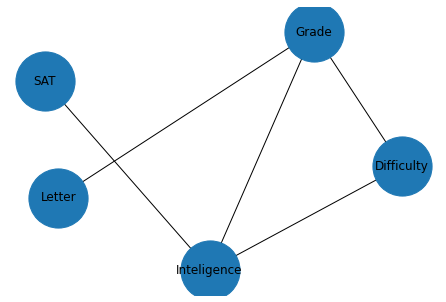

In [ ]:
import networkx as nx
import pylab as plt
nx.draw(model, node_size=3500,with_labels=True)
plt.show()

In [ ]:

phi_D_G = DiscreteFactor(['Difficulty', 'Grade'], [2, 2],  np.random.rand(4)) 
phi_D_I = DiscreteFactor(['Difficulty', 'Inteligence'], [2, 2],  np.random.rand(4)) 
phi_G_L = DiscreteFactor(['Grade', 'Letter'], [2, 2],  np.random.rand(4)) 
phi_G_I = DiscreteFactor(['Grade', 'Inteligence'], [2, 2],  np.random.rand(4))
phi_I_S = DiscreteFactor(['Inteligence', 'SAT'], [2, 2],  np.random.rand(4) )



In [ ]:
model.get_local_independencies()

(Difficulty ⟂ Letter, SAT | Inteligence, Grade)
(Inteligence ⟂ Letter | Difficulty, Grade, SAT)
(Grade ⟂ SAT | Inteligence, Difficulty, Letter)
(SAT ⟂ Difficulty, Letter, Grade | Inteligence)
(Letter ⟂ Inteligence, Difficulty, SAT | Grade)

In [ ]:
print(phi_D_G)

+---------------+----------+-------------------------+
| Difficulty    | Grade    |   phi(Difficulty,Grade) |
+===============+==========+=========================+
| Difficulty(0) | Grade(0) |                  0.0854 |
+---------------+----------+-------------------------+
| Difficulty(0) | Grade(1) |                  0.6090 |
+---------------+----------+-------------------------+
| Difficulty(1) | Grade(0) |                  0.6485 |
+---------------+----------+-------------------------+
| Difficulty(1) | Grade(1) |                  0.0150 |
+---------------+----------+-------------------------+


In [ ]:
print(phi_D_I)

+---------------+----------------+-------------------------------+
| Difficulty    | Inteligence    |   phi(Difficulty,Inteligence) |
+===============+================+===============================+
| Difficulty(0) | Inteligence(0) |                        0.1498 |
+---------------+----------------+-------------------------------+
| Difficulty(0) | Inteligence(1) |                        0.7365 |
+---------------+----------------+-------------------------------+
| Difficulty(1) | Inteligence(0) |                        0.8513 |
+---------------+----------------+-------------------------------+
| Difficulty(1) | Inteligence(1) |                        0.7189 |
+---------------+----------------+-------------------------------+


In [ ]:
print(phi_G_L)

+----------+-----------+---------------------+
| Grade    | Letter    |   phi(Grade,Letter) |
+==========+===========+=====================+
| Grade(0) | Letter(0) |              1.0000 |
+----------+-----------+---------------------+
| Grade(0) | Letter(1) |            100.0000 |
+----------+-----------+---------------------+
| Grade(1) | Letter(0) |            100.0000 |
+----------+-----------+---------------------+
| Grade(1) | Letter(1) |              1.0000 |
+----------+-----------+---------------------+


In [ ]:
print(phi_G_I)

+----------+----------------+--------------------------+
| Grade    | Inteligence    |   phi(Grade,Inteligence) |
+==========+================+==========================+
| Grade(0) | Inteligence(0) |                 100.0000 |
+----------+----------------+--------------------------+
| Grade(0) | Inteligence(1) |                   1.0000 |
+----------+----------------+--------------------------+
| Grade(1) | Inteligence(0) |                   1.0000 |
+----------+----------------+--------------------------+
| Grade(1) | Inteligence(1) |                 100.0000 |
+----------+----------------+--------------------------+


In [ ]:
print(phi_I_S)

+----------------+--------+------------------------+
| Inteligence    | SAT    |   phi(Inteligence,SAT) |
+================+========+========================+
| Inteligence(0) | SAT(0) |               100.0000 |
+----------------+--------+------------------------+
| Inteligence(0) | SAT(1) |                 1.0000 |
+----------------+--------+------------------------+
| Inteligence(1) | SAT(0) |                 1.0000 |
+----------------+--------+------------------------+
| Inteligence(1) | SAT(1) |               100.0000 |
+----------------+--------+------------------------+


[('Inteligence', 'Difficulty'), ('Inteligence', 'Grade'), ('Inteligence', 'SAT'), ('Difficulty', 'Grade'), ('Grade', 'Letter')]
<class 'graphviz.dot.Digraph'>


/usr/local/lib/python3.7/dist-packages/pgmpy/models/MarkovModel.py:10: FutureWarning: MarkovModel has been renamed to MarkovNetwork. Please use MarkovNetwork class, MarkovModel will be removed in future.
  FutureWarning,


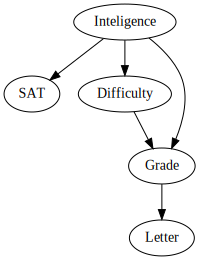

In [ ]:
model.add_factors(phi_D_G, phi_D_I, phi_G_L, phi_G_I,phi_I_S) 
bayesian_model = model.to_bayesian_model() 
print(bayesian_model.edges() )

modelMN = CausalGraphicalModel(nodes = bayesian_model.nodes(), edges=bayesian_model.edges())

dot = modelMN.draw()
print(type(dot))
display(dot)